In [1]:
%matplotlib inline

In [2]:
import pandas as pd

In [3]:
all_data = pd.read_csv('./data/review_features.csv', low_memory=False)

In [97]:
data = all_data.sample(20000, random_state=1)
cols_to_drop = ['access', 'amenities_', 'description', \
               'house_rules', 'id', 'host_verifications', 'last_review', 'last_scraped', \
               'market', 'neighborhood_overview', 'neighbourhood', 'neighbourhood_cleansed', \
               'neighbourhood_group_cleansed', 'notes', 'street', 'summary', 'transit', \
               'Unnamed: 0', 'first_review', 'calendar_last_scraped', 'calendar_updated', 
               'review_scores_accuracy', 'review_scores_checkin', 'review_scores_cleanliness', \
                'review_scores_communication', 'review_scores_location']
data.loc[:, cols_to_drop]
data = data.drop(cols_to_drop, axis=1)

data = data.replace('f', 0)
data = data.replace('t', 1)
data = data.replace(r'[\$,]','', regex=True)
# data['review_scores_rating']


# Get a list of non-numeric columns so we can drop them
from collections import defaultdict

non_numeric_columns = defaultdict(int)

for d in data.values:
    for k, v in zip(data.columns, d):
        if 'Mission' == v:
            print k, v
        
        try: 
            float(v)
        except Exception as e:
            non_numeric_columns[k] += 1

print non_numeric_columns.keys()
# data = data.drop(non_numeric_columns.keys(), axis=1)

host_total_listings_count Mission
host_total_listings_count Mission
host_total_listings_count Mission
['bathrooms', 'host_has_profile_pic', 'cancellation_policy', 'host_neighbourhood', 'host_acceptance_rate', 'property_type', 'host_location', 'space', 'zipcode', 'host_since', 'host_identity_verified', 'host_listings_count', 'bedrooms', 'host_response_rate', 'host_about', 'calculated_host_listings_count', 'interaction', 'name', 'license', 'host_response_time', 'beds', 'cleaning_fee', 'host_name', 'guests_included', 'host_total_listings_count']


In [98]:
dependent_variable = 'review_scores_rating'

In [99]:
# Drop missing values from depedent variable
data = data.dropna(subset=[dependent_variable])

In [100]:
# read most correlated columns from csv, and drop them

corr_cols_to_drop = pd.read_csv('./correlated_columns.csv', encoding='utf8').values.reshape(1,-1).tolist()[0]

In [101]:
# drop review_ related columns
review_columns = defaultdict(int)
for c in data.columns:
    if 'review' in c:
        review_columns[c] += 1
review_columns.keys()

['reviews_per_month',
 'number_of_reviews',
 'review_scores_value',
 'review_scores_rating']

In [102]:
# Drop zipcode, longitude, latitude and such
others = ['zipcode', 'latitude', 'longitude', 'experiences_offered_none']

In [103]:
cols_to_drop = set(review_columns.keys()).union(non_numeric_columns.keys()).union(corr_cols_to_drop).union(others)
# cols_to_drop

In [146]:
# drop the columns that we do not need
X = data.drop(cols_to_drop, axis=1)
y = data[dependent_variable]

In [147]:
X.columns

Index([u'accommodates', u'availability_365', u'availability_60',
       u'extra_people', u'has_availability', u'host_id', u'host_is_superhost',
       u'instant_bookable', u'is_business_travel_ready', u'is_location_exact',
       ...
       u'amenities_waterfront', u'amenities_well_lit_path_to_entrance',
       u'amenities_wheelchair_accessible',
       u'amenities_wide_clearance_to_shower_and_toilet', u'amenities_wifi',
       u'amenities_window_guards', u'amenities_wireless_internet',
       u'bed_type_airbed', u'bed_type_couch', u'room_type_shared_room'],
      dtype='object', length=157)

In [148]:
# Double check that we don't see any columns that have "review" in them. 
for c in X.columns:
    if 'review' in c:
        print c

In [149]:
# Impute missing values using median for both independent and dependent variables

import numpy as np
from sklearn.preprocessing import Imputer


imp = Imputer(missing_values=np.nan, strategy='median', axis=1)
imp.fit(X)
X = imp.transform(X)

imp = Imputer(missing_values=np.nan, strategy='median', axis=1)
imp.fit(y)
y = imp.transform(y.values.reshape(-1,1))
y = y.ravel()

print X.shape
print y.shape


(15520, 157)
(15520,)


In [150]:
y = np.log(y+1)

In [151]:
# Divide each column by its variance

x_var = X.var(axis=0)

X = X / np.sqrt(x_var)

In [152]:
# Scale the independent and dependent variables
# Center the data around zero by subtracting the mean
# Scale it to unit variance
# This is helpful in PCA

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
scaler.fit(X)
X = scaler.transform(X)

scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
scaler.fit(y.reshape(-1,1))
y = scaler.transform(y.reshape(-1,1))
y = y.ravel()

In [153]:
print X.shape
print y.shape

(15520, 157)
(15520,)


In [122]:
# Try PCA
# from sklearn.decomposition import PCA, KernelPCA

# pca = PCA(n_components=100)
# X = pca.fit_transform(X)


In [154]:
print X.shape
print y.shape

(15520, 157)
(15520,)


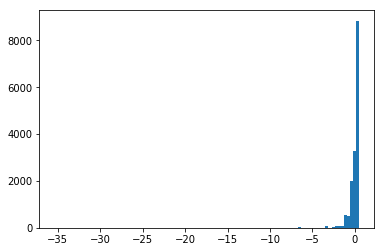

In [158]:
import matplotlib.pyplot as plt
y_lst = y.tolist()
plt.hist(y_lst, bins=100)
plt.show()

In [18]:
# Divide each feature in X by its variance


In [125]:
# Try KernelPCA
# from sklearn.decomposition import KernelPCA

# kcpa = KernelPCA(kernel='rbf', fit_inverse_transform=False)
# X = kcpa.fit_transform(X)

# print X.shape
# print y.shape

In [159]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.33, 
                                                    random_state=1234)

Mean squared error: 0.50
Variance score: 0.52


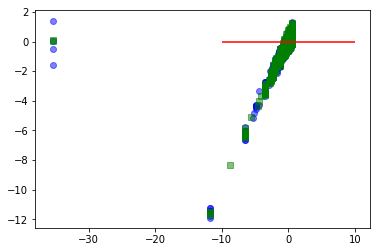

In [167]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, make_scorer, roc_auc_score

# Create linear regression object
regr = linear_model.Lasso(alpha=0.001, fit_intercept=False, max_iter=10000)

# Train the model using the training sets
regr.fit(X_train, y_train)

y_train_pred = regr.predict(X_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)

# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test.tolist(), y_pred.tolist()))

# Plot the residuals
plt.scatter(y_train, y_train-y_train_pred, c='b', marker='o', alpha=0.5)
plt.scatter(y_test, y_test-y_pred, c='g', marker='s', alpha=0.5)
plt.hlines(y=0, xmin=-10, xmax=10, color='r')
plt.show()

In [ ]:
def squared_err(org, prd):
    return sum((org-prd)**2)

In [ ]:
def coeff_of_determination(org, prd):
    mean_org = np.mean(org)
    mean_prd = [mean_org for y in org]
    squared_error_regr = squared_err(org, prd)
    print squared_error_regr 
    
    squared_error_y_mean = squared_err(org, mean_prd)
    print squared_error_y_mean
    
    return 1 - (squared_error_regr / squared_error_y_mean)

In [161]:
from sklearn import model_selection

from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR


kfold = model_selection.KFold(n_splits=10, random_state=1234)


def build_model(model_name):
    return model_name()

for model_name in [LinearRegression, Ridge, ElasticNet, \
                   AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor, SVR]:
    
    model = build_model(model_name)
    results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring='r2')
    print model_name, results.mean()
    

<class 'sklearn.linear_model.base.LinearRegression'> -4.666226790771289e+18
<class 'sklearn.linear_model.ridge.Ridge'> 0.32598384890514986
<class 'sklearn.linear_model.coordinate_descent.ElasticNet'> 0.05575253209133191
<class 'sklearn.ensemble.weight_boosting.AdaBoostRegressor'> -0.2891272839540341
<class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'> 0.4104192833471652
<class 'sklearn.ensemble.forest.RandomForestRegressor'> 0.4489235660016785
<class 'sklearn.svm.classes.SVR'> 0.06445139688300101
